In [1]:
import pandas as pd
import numpy as np

In [2]:
temp_df = pd.read_csv("C:\\Users\\Лев\\Projects\\Diploma\\sbp2.csv", sep=';')
temp_df['time'] = pd.to_datetime(temp_df['time'], dayfirst=True)
temp_df = temp_df.sort_values(by=['time'])
temp = pd.DataFrame(pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h'), columns=['time'])
temp = temp.set_index('time').join(temp_df.set_index('time'), how='left')
temp = temp['T'].ffill()
temp.index = pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h')

In [3]:
temp_train, temp_test = temp.iloc[:-2922], temp.iloc[-2922:]

In [26]:
import warnings 
warnings.filterwarnings('ignore')

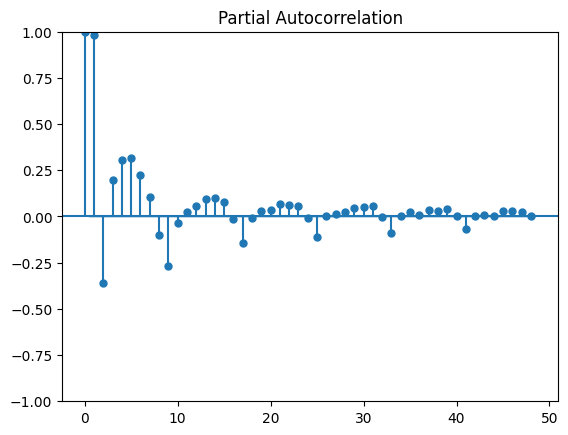

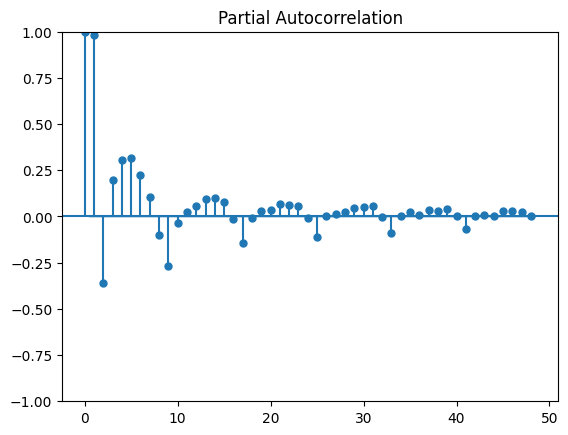

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(temp_train)

In [25]:
from sktime.forecasting.arima import ARIMA

arima_model = ARIMA(order=(7,1,5), seasonal_order=(1,0,1,8))
arima_model.fit(temp_train[-10000:])
np.mean(np.abs(arima_model.predict_residuals()))

c:\Users\Лев\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.8733330173775727

In [14]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                10000
Model:             SARIMAX(10, 1, 5)x(1, 0, [1], 16)   Log Likelihood              -16221.394
Date:                               Fri, 10 May 2024   AIC                          32480.788
Time:                                       18:52:27   BIC                          32617.783
Sample:                                   09-16-2019   HQIC                         32527.160
                                        - 02-17-2023                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.003     -0.059      0.953      -0.005       0.005
ar.L1         -0.3970      0.108     -3.691      0.000      -0.608      -0.186
ar.L2          0.1409      0.057      2.458      0.014       0.029       0.253
ar.L3         -0.3655      0.052     -7.040      0.000      -0.467      -0.264
ar.L4         -0.7935      0.059    -13.421      0.000      -0.909      -0.678
ar.L5         -0.4903      0.100     -4.904      0.000      -0.686      -0.294
ar.L6         -0.0842      0.015     -5.482      0.000      -0.114      -0.054
ar.L7         -0.1286      0.016     -8.250      0.000      -0.159      -0.098
ar.L8         -0.0285      0.013     -2.221      0.026      -0.054      -0.003
ar.L9         -0.0642      0.012     -5.381      0.000      -0.088      -0.041
ar.L10        -0.0840      0.011     -7.801      0.000      -0.105      -0.063
ma.L1          0.5254      0.108      4.878      0.000       0.314       0.737
ma.L2         -0.1765      0.055     -3.219      0.001      -0.284      -0.069
ma.L3          0.2125      0.047      4.480      0.000       0.120       0.305
ma.L4          0.6941      0.052     13.465      0.000       0.593       0.795
ma.L5          0.4661      0.090      5.181      0.000       0.290       0.642
ar.S.L16       0.9766      0.004    265.289      0.000       0.969       0.984
ma.S.L16      -0.9197      0.007   -130.574      0.000      -0.933      -0.906
sigma2         1.4991      0.013    112.166      0.000       1.473       1.525
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              7996.52
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.31
Prob(H) (two-sided):                  0.89   Kurtosis:                         7.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

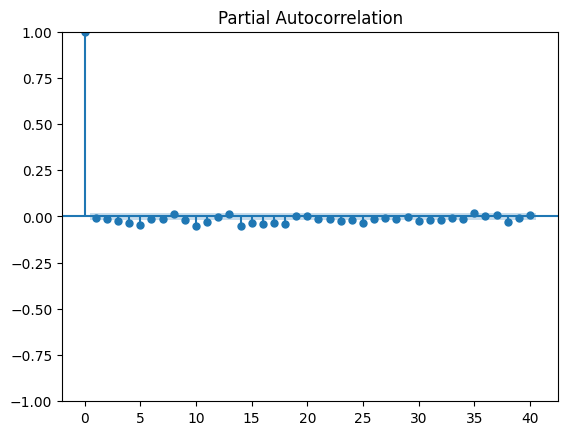

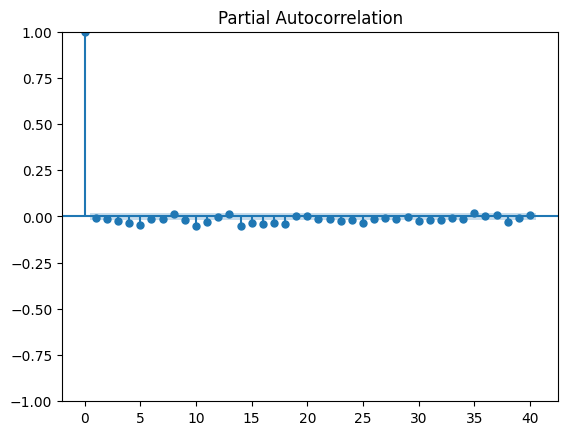

In [31]:
plot_pacf(arima_model.predict_residuals()[1:])

In [6]:
def l2_improved(y_true, y_pred, indexes):
    if len(y_pred) != len(y_true):
        print("Lenghts are not the same!")
        return 0
    hour_vars = {0:     0.831691, 
                 3:     1.450059,
                 6:	    1.757970,
                 9:	    0.475864,
                 12:    0.629008,
                 15:	0.960935,
                 18:	1.110826,
                 21:	0.783646}
    s = 0
    n = len(y_true)
    for i in range(n):
        s += (y_true[i] - y_pred[i]) ** 2 * hour_vars[indexes[i]]
    return s / n

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='T'>)

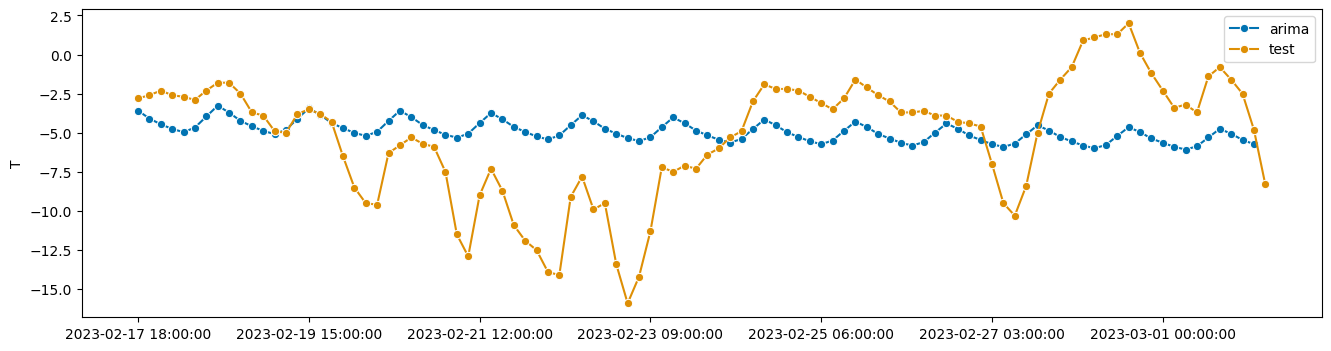

In [59]:
from sktime.utils.plotting import plot_series

plot_series(arima_model.predict(range(1,100)), temp_test[:100], labels=['arima', 'test'])

In [17]:
temp_test.shape

(2922,)

In [27]:
results = np.array([arima_model.predict(range(1,25))])

for i in range(200):
    print(round(i / 200, 4))
    arima_model.update(temp_test[9*i:9*(i+1)], update_params=True)
    results = np.append(results, [arima_model.predict(range(1,25))], axis=0)

0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.175
0.18
0.185
0.19
0.195
0.2
0.205
0.21
0.215
0.22
0.225
0.23
0.235
0.24
0.245
0.25
0.255
0.26
0.265
0.27
0.275
0.28
0.285
0.29
0.295
0.3
0.305
0.31
0.315
0.32
0.325
0.33
0.335
0.34
0.345
0.35
0.355
0.36
0.365
0.37
0.375
0.38
0.385
0.39
0.395
0.4
0.405
0.41
0.415
0.42
0.425
0.43
0.435
0.44
0.445
0.45
0.455
0.46
0.465
0.47
0.475
0.48
0.485
0.49
0.495
0.5
0.505
0.51
0.515
0.52
0.525
0.53
0.535
0.54
0.545
0.55
0.555
0.56
0.565
0.57
0.575
0.58
0.585
0.59
0.595
0.6
0.605
0.61
0.615
0.62
0.625
0.63
0.635
0.64
0.645
0.65
0.655
0.66
0.665
0.67
0.675
0.68
0.685
0.69
0.695
0.7
0.705
0.71
0.715
0.72
0.725
0.73
0.735
0.74
0.745
0.75
0.755
0.76
0.765
0.77
0.775
0.78
0.785
0.79
0.795
0.8
0.805
0.81
0.815
0.82
0.825
0.83
0.835
0.84
0.845
0.85
0.855
0.86
0.865
0.87
0.875
0.88
0.885
0.89
0.895
0.9
0.905
0.91
0.91

In [28]:
np.save("arima2res", results)

In [7]:
results = np.load("arima2res.npy")

1.0020775373414879

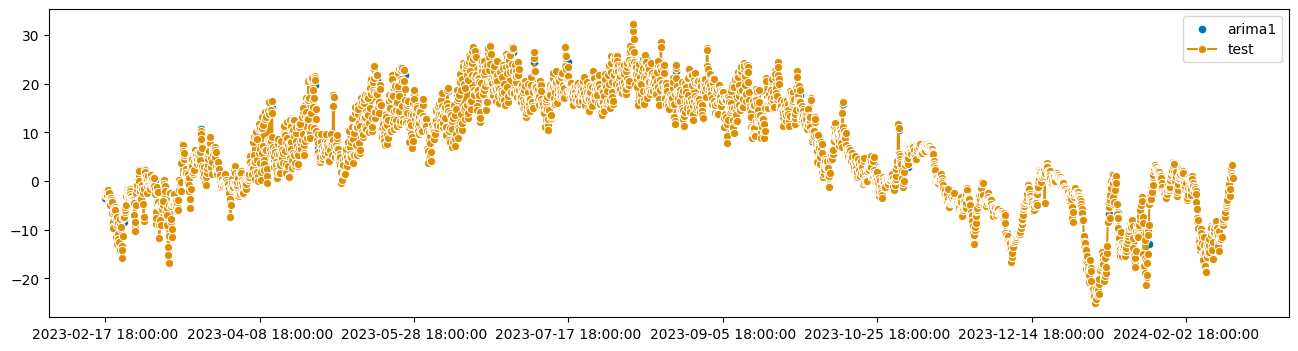

In [62]:
results_3h = pd.Series(results[:,0])
results_3h.index = temp_test[[8*i for i in range(359)]].index

from sktime.utils.plotting import plot_series

plot_series(results_3h, temp_test, labels = ['arima1', 'test'])

In [30]:
maes = [l2_improved(results[:,j], temp_test[[9*i + j for i in range(201)]], temp_test.index[[9*i + j for i in range(201)]].hour) for j in range(24)]

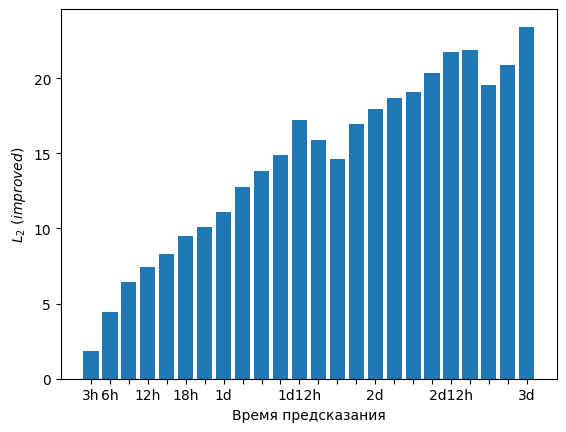

In [31]:
import matplotlib.pyplot as plt

names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']
plt.bar(x=names, height=maes)
plt.xlabel("Время предсказания")
plt.ylabel("$L_2 \\ (improved)$")
plt.show()

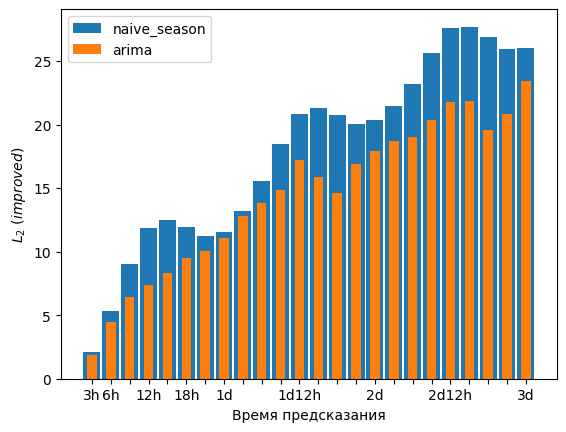

In [32]:
day_diff = [np.mean([temp_train[8 * i + j + 1] - temp_train[8 * i + j] for i in range(1, 6560)]) for j in range(8)]
maes_s = []
temp_test_predict = temp_test.values.copy()
for i in range(24):
    for j in range(len(temp_test_predict)):
        temp_test_predict[j] += day_diff[(j + i+ 6) % 8]
    maes_s.append(l2_improved(temp_test_predict[:-(i + 1)], temp_test[(i + 1):].values, temp_test.index[(i + 1):].hour))

import matplotlib.pyplot as plt

names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']
plt.bar(x=names, height=maes_s, width=0.9 , label='naive_season')
plt.bar(x=names, height=maes, width=0.5, label='arima')
plt.xlabel("Время предсказания")
plt.ylabel("$L_2 \\ (improved)$")
plt.legend()
plt.show()

In [76]:
temp_test

2023-02-17 18:00:00   -2.8
2023-02-17 21:00:00   -2.6
2023-02-18 00:00:00   -2.3
2023-02-18 03:00:00   -2.6
2023-02-18 06:00:00   -2.7
                      ... 
2024-02-17 09:00:00    2.3
2024-02-17 12:00:00    2.9
2024-02-17 15:00:00    3.3
2024-02-17 18:00:00    1.0
2024-02-17 21:00:00    0.6
Freq: 3H, Name: T, Length: 2922, dtype: float64